# Shopping Mall development in Charlotte, North Carolina, U.S.A.


### Overview
- Obtain the locations of existing shopping malls offered by the town's governmental data portal http://data.charlottenc.gov¶
- Build a dataframe of neighborhoods in Charlotte, NC by web scraping the data from Wikipedia page
- Get the geographical coordinates of the neighborhoods
- Obtain business data (venues) for the neighborhoods via Foursquare's API
- Cluster the venue data
- Explore the clusters
- Compare Foursquare data with town's governmental data
- Offer recommendation for region suited for new Shopping Mall developments

Hint: for the maps drawn with folium you have to download the notebook, they will not show in the GitHub preview.

### 1. Import libraries

In [1]:
#!conda update conda-build

# library to handle data in a vectorized manner
import numpy as np

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# tranforming json file into a pandas dataframe library (Foursquare API)
from pandas.io.json import json_normalize

# library to handle JSON files delivered by Foursquare
import json

# convert an address into latitude and longitude values - remove hashtag if you need to install geopy
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

#!pip install geocoder
import geocoder

# library to handle requests from foursquare
import requests

# downloads webpages four beautifulsoup - remove hashtag if you need  to instal uReq
#!conda install -c conda-forge urllib.request --yes
from urllib.request import urlopen as uReq

# library to parse HTML and XML documents
from bs4 import BeautifulSoup as soup 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library - remove hashtag if you need to install folium
#!conda install -c conda-forge folium --yes
import folium
from folium.features import DivIcon
print("Folium: ",folium.__version__)

# accessing wikipedia contents - remove hashtag if you need to install wikipedia api
#!pip install wikipedia-api
import wikipediaapi

print("Libraries imported.")

Folium:  0.5.0
Libraries imported.


### 2. Download Shopping Mall locations file from http://data.charlottenc.gov

Explore the data set on the website under: http://data.charlottenc.gov/datasets/existing-shopping-centers

In [2]:
filename = "https://opendata.arcgis.com/datasets/856c336323d046d0bb639171e38ccc46_11.csv"
headers = ["Longitude","Latitude","ObjectID","PID","AddressID","CenterName","CenterClassification","GlobalID"]

In [3]:
mallsdf = pd.read_csv(filename, names = headers, header=0)
mallsdf.head()

,Longitude,Latitude,ObjectID,PID,AddressID,CenterName,CenterClassification,GlobalID
0,-80.835940,35.206932,160,12524381,212327,Kings Court,Convenience,{5877A295-95C4-4373-A69E-00A69FECE4FA}
1,-80.728605,35.184475,233,16503601,387617,Idlewild Crossing,Convenience,{5B4B9778-E76F-411B-ADD3-015D8CECDFAE}
2,-80.891547,35.475693,213,00147C99,373426,Peninsula Village,Convenience,{0795493A-9022-48AF-97CF-01FB41CDB68D}
3,-80.783609,35.371177,84,02931104,374638,Shoppes at Highland Creek,Convenience,{777944F1-C731-4785-B030-02137E90B3D6}
4,-80.697485,35.118550,39,21510102,246304,Fullwood Plaza,Convenience,{57164D78-AEEA-4122-A9CA-027AF80FA3E7}


How many shopping malls does the data set contain?

In [4]:
mallsdf.shape

(243, 8)

Downloading the public csv contains a lot of extra GIS feature columns we do not necessarily need for our work. Let's remove them.

In [5]:
mallsdf.drop(columns=['ObjectID','PID','AddressID','GlobalID'], inplace=True)
mallsdf.head()

,Longitude,Latitude,CenterName,CenterClassification
0,-80.835940,35.206932,Kings Court,Convenience
1,-80.728605,35.184475,Idlewild Crossing,Convenience
2,-80.891547,35.475693,Peninsula Village,Convenience
3,-80.783609,35.371177,Shoppes at Highland Creek,Convenience
4,-80.697485,35.118550,Fullwood Plaza,Convenience


In case the data frame contains any null values (NaN), let us drop all incomplete rows.

In [6]:
mallsdf = mallsdf.dropna()
mallsdf.shape

(242, 4)

One mall entry had to be removed that had no classification. What kind of mall classes are there and how many are in these classes?

In [7]:
mallsdf.CenterClassification.value_counts()

Convenience       88
Neighborhood      71
Community         45
Regional          32
Super-Regional     6
Name: CenterClassification, dtype: int64

In [8]:
mallsdfsuper = mallsdf.loc[mallsdf['CenterClassification'] == 'Super-Regional'].reset_index(drop=True)

mallsdfsuper

,Longitude,Latitude,CenterName,CenterClassification
0,-80.827752,35.371802,Bryton Town Center,Super-Regional
1,-80.881616,35.108257,Carolina Pavillion,Super-Regional
2,-80.879617,35.082739,Carolina Place Mall,Super-Regional
3,-80.848820,35.354615,Northlake Mall,Super-Regional
4,-80.761887,35.292960,Belgate,Super-Regional
5,-80.828434,35.151490,SouthPark Mall,Super-Regional


In [9]:
# get the coordinates of Charlotte, North Carolina
address = 'Charlotte, USA'

geolocator = Nominatim(user_agent="CLT analysis")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of {}: {}, {}.'.format(address, latitude, longitude))

The geograpical coordinates of Charlotte, USA: 35.2270869, -80.8431268.


In [10]:
CLT_coordinates = (latitude, longitude)

mall_map = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {'Convenience' : 'red', 'Neighborhood' : 'blue', 'Community' : 'green', 'Regional' : 'yellow', 'Super-Regional' : 'black'}
radiusdict = {'Convenience' : '3', 'Neighborhood' : '5', 'Community' : '7', 'Regional' : '9', 'Super-Regional' : '10'}


for _, row in mallsdf.iterrows():
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                fill=True, radius=radiusdict[row['CenterClassification']], fill_opacity=0.7, color=colorsdict[row['CenterClassification']]
                                ).add_to(mall_map)

# display map
mall_map

Below is the code for a different version of the map with class labels (latest folium required).

In [ ]:
mall_map = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {'Convenience' : 'red', 'Neighborhood' : 'blue', 'Community' : 'green', 'Regional' : 'pink', 'Super-Regional' : 'black'}
radiusdict = {'Convenience' : '3', 'Neighborhood' : '5', 'Community' : '7', 'Regional' : '9', 'Super-Regional' : '10'}


for _, row in mallsdf.iterrows():
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                        fill=True, radius=radiusdict[row['CenterClassification']], fill_opacity=0.7, color=colorsdict[row['CenterClassification']]
                        ).add_to(mall_map)
    folium.Marker(location=[row["Latitude"], row["Longitude"]],
                  icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),html='<div style="font-size: 12pt; color : {}">{}</div>'.format(colors[row['CenterClassification']], row['CenterClassification']))
                  ).add_to(mall_map)
# display map
mall_map

We have five different classes based on size and reach. Let's display these malls on a map.

In [12]:
mallsdf = mallsdf[mallsdf.CenterClassification == 'Super-Regional']
mallsdf.reset_index(inplace=True)
print('There are', mallsdf.shape[0],'large malls in Charlotte.')

There are 6 large malls in Charlotte.


In [13]:
mallsdf

,index,Longitude,Latitude,CenterName,CenterClassification
0,50,-80.827752,35.371802,Bryton Town Center,Super-Regional
1,68,-80.881616,35.108257,Carolina Pavillion,Super-Regional
2,167,-80.879617,35.082739,Carolina Place Mall,Super-Regional
3,181,-80.848820,35.354615,Northlake Mall,Super-Regional
4,182,-80.761887,35.292960,Belgate,Super-Regional
5,223,-80.828434,35.151490,SouthPark Mall,Super-Regional


Now that all the clutter is gone, let's see where these large malls are located.

In [14]:
mall_map2 = folium.Map(location=CLT_coordinates, zoom_start=11)

for _, row in mallsdf.iterrows():
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                fill=True, radius=10, fill_opacity=0.7, color='black'
                                ).add_to(mall_map2)
# display map
mall_map2

Run the code below for a different version of the map with class labels (latest folium required).

In [ ]:
mall_map2 = folium.Map(location=CLT_coordinates, zoom_start=11)

for _, row in mallsdf.iterrows():
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
                                fill=True, radius=10, fill_opacity=0.7, color='black'
                                ).add_to(mall_map2)
    folium.Marker(location=[row["Latitude"], row["Longitude"]],
                  icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),
                  html='<div style="font-size: 12pt; color : {}">{}</div>'.format(colors[row['CenterName']], row['CenterName']))
                  ).add_to(mall_map2)
# display map
mall_map2

### 3. Webscrape the neighborhoods with Wikipedia API and Beautiful Soup

We will assess which neighborhood may be suitable for the project. We need to know the boroughs and neighborhoods of Charlotte.
Let's look into Wikipedia and see what information they offer. A quick search yields that ther is an entry called  ["List of Charlotte neighborhoods"](https://en.wikipedia.org/wiki/List_of_Charlotte_neighborhoods).

#### The Wikipedia-Api lets us scrape their web content conveniently without html tags.

In [15]:
# eheck if the site exists and is accessible
wiki_wiki = wikipediaapi.Wikipedia('en')

page_py = wiki_wiki.page('List_of_Charlotte_neighborhoods')
print("Page - Exists: %s" % page_py.exists())

Page - Exists: True


The section titles are named after the Charlotte boroughs.

In [16]:
boroughs = []

def print_sectiontitles(sections, level=0):
        for s in sections:
                boroughs.append(s.title)
                
print_sectiontitles(page_py.sections)

print("There are",len(boroughs)," boroughs in Charlotte and are called: ", "\n".join([s.title for s in page_py.sections]))

There are 5  boroughs in Charlotte and are called:  South Charlotte
West Charlotte
North Charlotte
East Charlotte
Center City


#### Beautiful Soup searches the html source code

First step is downloading the html locally.

In [17]:
# downloading the html from Wikipedia
my_url = 'https://en.wikipedia.org/wiki/List_of_Charlotte_neighborhoods'

# opening webpage connection and downloading html
uClient = uReq(my_url)

# read downloaded html
page_html = uClient.read().decode()

with open('charlotte_neighborhoods.html', 'w') as fo:
    fo.write(page_html)

# close connection again (but with open should do the job already)
uClient.close()

The second step is opening the html with beautifulsoup. Since this page is rather messy and does not have a convenient table structure. We need to use some more complicated extraction methods.

In [18]:
# Load html file.
page_html = open('charlotte_neighborhoods.html').read()

# Turn into soup
page_soup = soup(page_html, 'html.parser')

In [19]:
# get from html all list tags
neighborhoodsli = page_soup.find_all('li')

# extract the text of each tag
neighborhoodsli = []
for tag in page_soup.find_all("li", recursive=True): 
    neighborhoodsli.append(tag.text)

# only keep neighborhood items
neighborhoodsli = neighborhoodsli[6:-158]

# only keep the first two words of each item
neighborhoodsfirsttwo = []
for neighborhood in neighborhoodsli:
    blergh = " ".join(neighborhood.split()[:2])
    neighborhoodsfirsttwo.append(blergh)

# remove unwanted words in 1-word neighborhoods
neighborhoods = []
stopwords = ['is','a','located','central','the','consisting','in','area','centered','built']
for foo in neighborhoodsfirsttwo:
    querywords = foo.split()
    resultwords = [word for word in querywords if word.lower() not in stopwords]
    neighborhoods.append(' '.join(resultwords))

# remove commas
neighborhoods2 = []
for x in neighborhoods:
    neighborhoods2.append(x.replace(',', ''))

# remove some extra string that was a glitch in the html (easiest with a pandas series)
neighborhoods = pd.Series(neighborhoods2).replace({'Cameron Woodbuilt':'Cameron Wood','Historic South':'South End'})

print("Number of Charlotte neighborhoods: ",len(neighborhoods))
neighborhoods

Number of Charlotte neighborhoods:  87


0                Arboretum
1                  Ayrsley
2               Ballantyne
3            Barclay Downs
4            Beverly Woods
5                 Blakeney
6             Cameron Wood
7           Carmel Village
8                Chantilly
9                   Cherry
10                Cotswold
11                Dilworth
12                Eastover
13           Grier Heights
14               South End
15              Landsdowne
16            Madison Park
17              Myers Park
18            Nations Ford
19                Parkdale
20              Piper Glen
21            Quail Hollow
22                 Raeburn
23              Sedgefield
24               SouthPark
25               Starmount
26            Steele Creek
27               Yorkshire
28             Ashley Park
29         Dixie/Berryhill
30             Biddleville
31             Camp Greene
32            Clanton Park
33               Reid Park
34                Coulwood
35            Enderly Park
36         Lincoln Heights
3

Split neighborhoods into boroughs

In [20]:
# the first listed borough is South Charlotte
neighborhoodsSC =[]
remainder1 = []

# crate a South Charlotte List that breaks at the last South Charlotte neighborhood
for item in neighborhoods:
    if item != 'Yorkshire': neighborhoodsSC.append(item)
    else:
        neighborhoodsSC.append(item)
        break

# remove South Charlotte neighborhoods from remaining neighborhoods
remainder1 = [x for x in neighborhoods if x not in neighborhoodsSC]

print("There are",len(neighborhoodsSC),"neighborhoods in South Charlotte.")
neighborhoodsSC

There are 28 neighborhoods in South Charlotte.


['Arboretum',
 'Ayrsley',
 'Ballantyne',
 'Barclay Downs',
 'Beverly Woods',
 'Blakeney',
 'Cameron Wood',
 'Carmel Village',
 'Chantilly',
 'Cherry',
 'Cotswold',
 'Dilworth',
 'Eastover',
 'Grier Heights',
 'South End',
 'Landsdowne',
 'Madison Park',
 'Myers Park',
 'Nations Ford',
 'Parkdale',
 'Piper Glen',
 'Quail Hollow',
 'Raeburn',
 'Sedgefield',
 'SouthPark',
 'Starmount',
 'Steele Creek',
 'Yorkshire']

In [21]:
# crate a West Charlotte List that breaks at the last West Charlotte neighborhood
neighborhoodsWC =[]
remainder2 = []

for item in remainder1:
    if item != 'Yorkmount Park': neighborhoodsWC.append(item)
    else:
        neighborhoodsWC.append(item)
        break

# remove West Charlotte neighborhoods from remaining neighborhoods
remainder2 = [x for x in remainder1 if x not in neighborhoodsWC]

print("There are",len(neighborhoodsWC),"neighborhoods in West Charlotte.")
neighborhoodsWC

There are 22 neighborhoods in West Charlotte.


['Ashley Park',
 'Dixie/Berryhill',
 'Biddleville',
 'Camp Greene',
 'Clanton Park',
 'Reid Park',
 'Coulwood',
 'Enderly Park',
 'Lincoln Heights',
 'Mountain Island',
 'Oakview Terrace',
 'Paw Creek',
 'Revolution Park',
 'Shopton',
 'Shuffletown',
 'Thomasboro/Hoskins',
 'Todd Park',
 'Washington Heights',
 'Wesley Heights',
 'Wilmore',
 'Westerly Hills',
 'Yorkmount Park']

In [22]:
# crate a North Charlotte list that breaks at the last North Charlotte neighborhood
neighborhoodsNC =[]
remainder3 = []

for item in remainder2:
    if item != 'Wilson Heights': neighborhoodsNC.append(item)
    else:
        neighborhoodsNC.append(item)
        break

# remove North Charlotte neighborhoods from remaining neighborhoods
remainder3 = [x for x in remainder2 if x not in neighborhoodsNC]

print("There are",len(neighborhoodsNC),"neighborhoods in North Charlotte.")
neighborhoodsNC

There are 15 neighborhoods in North Charlotte.


['Belmont',
 'College Downs',
 'Croft',
 'Derita',
 'Eastfield/Prosperity',
 'Hidden Valley',
 'Highland Creek',
 'Lockwood',
 'Newell',
 'NoDa',
 'Northlake',
 'Tryon Hills',
 'University City',
 'Villa Heights',
 'Wilson Heights']

In [23]:
# crate an East Charlotte list that breaks at the last East Charlotte neighborhood
neighborhoodsEC =[]
remainder4 = []

for item in remainder3:
    if item != 'Coventry Woods': neighborhoodsEC.append(item)
    else:
        neighborhoodsEC.append(item)
        break

# remove North Charlotte neighborhoods from remaining neighborhoods
remainder4 = [x for x in remainder3 if x not in neighborhoodsEC]

print("There are",len(neighborhoodsEC),"neighborhoods in East Charlotte.")
neighborhoodsEC

There are 19 neighborhoods in East Charlotte.


['Easthaven',
 'Eastland',
 'Grove Park',
 'Hickory Grove',
 'Hickory Ridge',
 'Idlewild',
 'Mint Hill',
 'Oakhurst',
 'Plaza Hills',
 'Plaza-Midwood',
 'Ravenwood',
 'Reedy Creek',
 'Shamrock',
 'Sardis Woods',
 'Sheffield Park',
 'Sherwood Forest',
 'Stonehaven',
 'Windsor Park',
 'Coventry Woods']

In [24]:
neighborhoodscenter = remainder4

print("There are",len(neighborhoodscenter),"neighborhoods in Center City.")
neighborhoodscenter

There are 3 neighborhoods in Center City.


['Uptown', 'Elizabeth', 'Midtown']

Create a dataframe into which all our data gets saved for further analysis

In [25]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# instantiate the dataframe
neighborhoodsdf = pd.DataFrame(columns=column_names)

neighborhoodsdf

,Borough,Neighborhood,Latitude,Longitude


Loop all the five boroughs into the data frame. With a nested loop this may be more elegant.

In [26]:
for row in neighborhoodsSC:
    neighborhoodsdf = neighborhoodsdf.append({'Borough': boroughs[0],
                                              'Neighborhood': row,},
                                              ignore_index=True)
for row in neighborhoodsWC:
    neighborhoodsdf = neighborhoodsdf.append({'Borough': boroughs[1],
                                              'Neighborhood': row,},
                                              ignore_index=True)
for row in neighborhoodsNC:
    neighborhoodsdf = neighborhoodsdf.append({'Borough': boroughs[2],
                                              'Neighborhood': row,},
                                              ignore_index=True)
for row in neighborhoodsEC:
    neighborhoodsdf = neighborhoodsdf.append({'Borough': boroughs[3],
                                              'Neighborhood': row,},
                                              ignore_index=True)
for row in neighborhoodscenter:
    neighborhoodsdf = neighborhoodsdf.append({'Borough': boroughs[4],
                                              'Neighborhood': row,},
                                              ignore_index=True)
neighborhoodsdf

,Borough,Neighborhood,Latitude,Longitude
0,South Charlotte,Arboretum,NaN,NaN
1,South Charlotte,Ayrsley,NaN,NaN
2,South Charlotte,Ballantyne,NaN,NaN
3,South Charlotte,Barclay Downs,NaN,NaN
4,South Charlotte,Beverly Woods,NaN,NaN
5,South Charlotte,Blakeney,NaN,NaN
6,South Charlotte,Cameron Wood,NaN,NaN
7,South Charlotte,Carmel Village,NaN,NaN
8,South Charlotte,Chantilly,NaN,NaN
9,South Charlotte,Cherry,NaN,NaN


#### Geocoding

Add the coordinates into our data frame.

In [27]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Charlotte, NC'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [28]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [get_latlng(neighborhood) for neighborhood in neighborhoodsdf["Neighborhood"].tolist()]

print('We gathered',len(coords),'coordinates.')
coords[:5]

We gathered 87 coordinates.


[[35.103442387648165, -80.77854038240778],
 [35.1385614081375, -80.93535495364944],
 [35.11810816769689, -80.839752763908],
 [35.16086000000007, -80.83742999999998],
 [35.13531000000006, -80.84378999999996]]

In [29]:
# create temporary dataframe to populate the coordinates into Latitude and Longitude
coordsdf = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [30]:
# merge the coordinates into the original dataframe
neighborhoodsdf['Latitude'] = coordsdf['Latitude']
neighborhoodsdf['Longitude'] = coordsdf['Longitude']

neighborhoodsdf.head()

,Borough,Neighborhood,Latitude,Longitude
0,South Charlotte,Arboretum,35.103442,-80.778540
1,South Charlotte,Ayrsley,35.138561,-80.935355
2,South Charlotte,Ballantyne,35.118108,-80.839753
3,South Charlotte,Barclay Downs,35.160860,-80.837430
4,South Charlotte,Beverly Woods,35.135310,-80.843790


Let's plot up these new coordinates.

In [31]:
# create map of Charlotte
mall_map3 = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {'South Charlotte' : 'red', 'West Charlotte' : 'blue', 'North Charlotte' : 'green', 'East Charlotte' : 'purple', 'Center City' : 'magenta'}

# add markers to map
for _, row in neighborhoodsdf.iterrows():
    label = '{}, {}'.format(row["Neighborhood"],row["Borough"]) # create a label for each row
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        popup=label,
        color=colorsdict[row['Borough']],
        fill=True,
        fill_opacity=1).add_to(mall_map3)  

# call the map
mall_map3

#### Fixing buggy coordinates

Let's evaluate this...

The borough colors suggest that the geocoder has missplaced. It seems that some road names are mistaken for neighborhoods. Midtown is placed in Nashville, Tennessee.

We must fix this manually. Visually, the missplaced neighborhoods are Parkdale, Midtown, Mint Hill, Ravenwood, and Raeburn.

In [32]:
# manually correct neighborhood coordinates
Parkdale_coords = (35.157097, -80.84493)
Midtown_coords =  (35.201040, -80.840689)
MintHill_coords =  (35.173462, -80.657054)
Ravenwood_coords =  (35.247038, -80.725075)
Raeburn_coords =  (35.059989, -80.812711)

In [33]:
# replace the coordinates for the problematic neighborhoods in the data frame       
neighborhoodsdf.loc[neighborhoodsdf.Neighborhood == 'Parkdale', ('Latitude','Longitude')] = Parkdale_coords
neighborhoodsdf.loc[neighborhoodsdf.Neighborhood == 'Midtown', ('Latitude','Longitude')] = Midtown_coords
neighborhoodsdf.loc[neighborhoodsdf.Neighborhood == 'Mint Hill', ('Latitude','Longitude')] = MintHill_coords
neighborhoodsdf.loc[neighborhoodsdf.Neighborhood == 'Ravenwood', ('Latitude','Longitude')] = Ravenwood_coords
neighborhoodsdf.loc[neighborhoodsdf.Neighborhood == 'Raeburn', ('Latitude','Longitude')] = Raeburn_coords

In [34]:
# create map of Charlotte
mall_map4 = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {'South Charlotte' : 'red', 'West Charlotte' : 'blue', 'North Charlotte' : 'green', 'East Charlotte' : 'purple', 'Center City' : 'magenta'}

# add markers to map
for _, row in neighborhoodsdf.iterrows():
    label = '{}, {}'.format(row["Neighborhood"],row["Borough"]) # create a label for each row
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        popup=label,
        color=colorsdict[row['Borough']],
        fill=True,
        fill_opacity=1).add_to(mall_map4)

# call the map
mall_map4

#### Save to CSV

This looks better now. Save the data set into a CSV file.

In [35]:
# save the fixed DataFrame as CSV file
neighborhoodsdf.to_csv("clt_neighborhoods.csv", index=False)

### 4. Use the Foursquare API characterize the neighborhoods

Enter your Foursquare API user credentials.

In [61]:
# @hidden_cell

CLIENT_ID = 'credential' # your Foursquare ID
CLIENT_SECRET = 'credential' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: credential
CLIENT_SECRET:credential


#### Making the Foursquare request

The radius parameter determines the search radius in meters around the neighborhood. The limit defines a maximum of venues per neighborhood query.

Requested are Names, Coordinates, and Type (category) of each venue.

In [37]:
radius = 2000
LIMIT = 100

venues = []

for lat, long, neighborhood in zip(neighborhoodsdf['Latitude'], neighborhoodsdf['Longitude'], neighborhoodsdf['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long,
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [38]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print("The venues data set contains",venues_df.shape[0],"venues.")
venues_df.head()

The venues data set contains 5160 venues.


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Arboretum,35.103442,-80.77854,Chick-fil-A,35.098873,-80.781388,Fast Food Restaurant
1,Arboretum,35.103442,-80.77854,Cajun Yard Dog,35.096891,-80.780155,Cajun / Creole Restaurant
2,Arboretum,35.103442,-80.77854,Noodles & Company,35.098383,-80.780545,Noodle House
3,Arboretum,35.103442,-80.77854,McAlister's Deli,35.097719,-80.779004,Deli / Bodega
4,Arboretum,35.103442,-80.77854,Manhattan Bagel,35.096958,-80.778843,Bagel Shop


Group the venue data set by neighborhood. Note the defined limit of 100 venues.

In [39]:
venues_df.groupby(["Neighborhood"]).count()

,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Neighborhood,,,,,,
Arboretum,59,59,59,59,59,59
Ashley Park,84,84,84,84,84,84
Ayrsley,96,96,96,96,96,96
Ballantyne,41,41,41,41,41,41
Barclay Downs,100,100,100,100,100,100
Belmont,100,100,100,100,100,100
Beverly Woods,48,48,48,48,48,48
Biddleville,65,65,65,65,65,65
Blakeney,69,69,69,69,69,69


#### How many and what kind of venue categories are present in Charlotte?

In [40]:
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 291 unique categories.


In [41]:
# print out the list of categories
venues_df['VenueCategory'].unique()[:50]

array(['Fast Food Restaurant', 'Cajun / Creole Restaurant',
       'Noodle House', 'Deli / Bodega', 'Bagel Shop', 'Salad Place',
       'Martial Arts Dojo', 'Southern / Soul Food Restaurant',
       'Italian Restaurant', 'Sandwich Place', 'Supermarket', 'Wine Shop',
       'Arts & Crafts Store', 'Bookstore', 'Bakery',
       'Furniture / Home Store', 'Clothing Store',
       'Health & Beauty Service', 'Breakfast Spot', 'Asian Restaurant',
       'Shopping Mall', 'Burger Joint', 'Bubble Tea Shop',
       'Movie Theater', 'Gym', 'American Restaurant', 'Cosmetics Shop',
       'Smoothie Shop', 'Video Game Store', 'High School', 'Golf Course',
       'Tex-Mex Restaurant', 'Coffee Shop', 'Mobile Phone Shop', 'Diner',
       'Mexican Restaurant', 'Shoe Store', 'Greek Restaurant',
       'Liquor Store', 'Pet Store', 'Bank', 'Salon / Barbershop',
       'Kids Store', 'Gift Shop', 'Music Store', 'Donut Shop', 'Gym Pool',
       'Spa', 'Building', 'Pool'], dtype=object)

#### Are there Shopping Malls in the data set?

In [42]:
# check if the results contain "Shopping Mall"
"Neighborhood" in venues_df['VenueCategory'].unique()

True

### 5. Analyze neighborhood venues

In [43]:
# one hot encoding
clt_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
clt_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [clt_onehot.columns[-1]] + list(clt_onehot.columns[:-1])
clt_onehot = clt_onehot[fixed_columns]

print("The one hot data frame is", clt_onehot.shape[0],"columns wide (one column for each venue category) and ", clt_onehot.shape[1],"rows long (one row per venue).")
clt_onehot.head()

The one hot data frame is 5160 columns wide (one column for each venue category) and  292 rows long (one row per venue).


,Neighborhoods,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Carpet Store,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Library,College Rec Center,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Other Repair Shop,Outlet Mall,Paintball Field,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residence,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Taxi,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Vape Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,

Let's characterize each neighborhood by taking the mean of each category

In [44]:
clt_grouped = clt_onehot.groupby(['Neighborhoods']).mean().reset_index()

print("Shape of data frame with per neighborhood venue means:", clt_grouped.shape)
clt_grouped.head()

Shape of data frame with per neighborhood venue means: (87, 292)


,Neighborhoods,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Carpet Store,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Gym,College Library,College Rec Center,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Event Space,Fabric Shop,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hardware Store,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hunting Supply,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Optical Shop,Other Nightlife,Other Repair Shop,Outlet Mall,Paintball Field,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pizza Place,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residence,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Rugby Pitch,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Synagogue,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Taxi,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Tree,Vape Store,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,

How many neighborhoods are in range of a shopping mall? 

In [45]:
len(clt_grouped[clt_grouped["Shopping Mall"] > 0])

15

#### Create a new data frame for Shopping Malls only

In [46]:
clt_mall = clt_grouped[["Neighborhoods","Shopping Mall"]]
clt_mall.head()

,Neighborhoods,Shopping Mall
0,Arboretum,0.016949
1,Ashley Park,0.000000
2,Ayrsley,0.000000
3,Ballantyne,0.024390
4,Barclay Downs,0.010000


Which neighborhoods do contain a shopping mall and how many neighborhoods do so?

In [47]:
clt_mallabundance = clt_mall.sort_values(by='Shopping Mall', ascending=True)
clt_mallabundance.drop(clt_mallabundance.loc[clt_mallabundance['Shopping Mall']==0].index, inplace=True)
clt_mallabundance = clt_mallabundance.reset_index(drop=True)

print('There are',clt_mallabundance.shape[0],'neighborhoods with shopping malls.')

There are 15 neighborhoods with shopping malls.


Let's combine this set of neighborhoods with shopping malls with the location data to characterize them better.

In [48]:
clt_mallabundance.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
abundance_merged = clt_mallabundance.join(neighborhoodsdf.set_index("Neighborhood"), on="Neighborhood")
abundance_merged

,Neighborhood,Shopping Mall,Borough,Latitude,Longitude
0,Barclay Downs,0.010000,South Charlotte,35.160860,-80.837430
1,Midtown,0.010000,Center City,35.201040,-80.840689
2,Cherry,0.010000,South Charlotte,35.210630,-80.830810
3,Parkdale,0.010000,South Charlotte,35.157097,-80.844930
4,Cameron Wood,0.010753,South Charlotte,35.104317,-80.852307
5,Cotswold,0.014493,South Charlotte,35.181190,-80.798340
6,Shamrock,0.016667,East Charlotte,35.239680,-80.788440
7,Arboretum,0.016949,South Charlotte,35.103442,-80.778540
8,Coventry Woods,0.017241,East Charlotte,35.176317,-80.808462
9,Croft,0.018182,North Charlotte,35.344620,-80.824050


Additionally, let's create a visual representation of the shopping mall abundance.

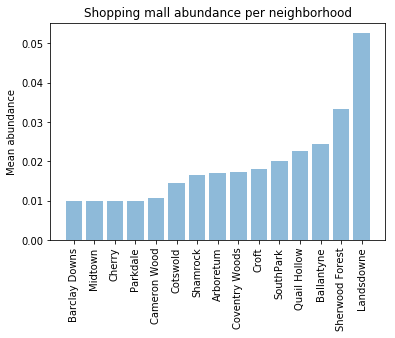

In [49]:
objects = clt_mallabundance['Neighborhood']
y_pos = np.arange(len(objects))

plt.bar(y_pos, clt_mallabundance['Shopping Mall'], align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
plt.ylabel('Mean abundance')
plt.title('Shopping mall abundance per neighborhood')

plt.show()

Landsdowne and Sherwood Forest are leading the Shopping Mall ranking with distance.

### 6. Clustering the neighborhoods

Which neighborhoods have similar abundances of shopping malls? Run k-means clustering to combine similar neighborhoods. Let's first run the elbow method to find the right k for our data set.

The idea behind elbow method is to run k-means clustering multiple times for different k. For each value of k we calculate the distortions. The more clusters we have, the closer they will come to the actual data points and progress to overfit. The goal is to bring down distortion, but keep a balance to avoid overfitting. We can plot a line graph of k vs distortion and visually determine a break point where distortion loss decreases.

Text(0.5, 1.0, 'Elbow curve')

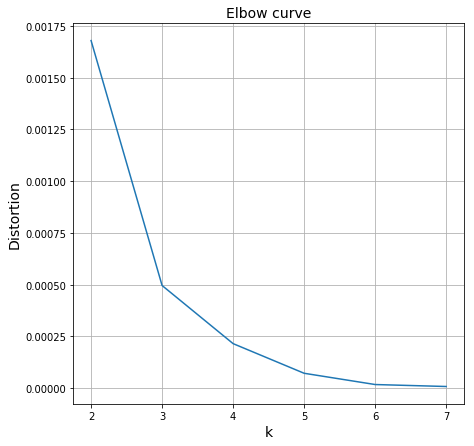

In [50]:
# remove the Neighborhoods names, otherwise creates error
clt_clustering = clt_mall.drop(["Neighborhoods"], 1)

# set up a loop that repeats k-means with a list of k's and measures distortion 
X = clt_clustering
distorsions = []
for k in range(2, 8):
    kmeans = KMeans(init="k-means++", n_clusters=k, n_init=12)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(7, 7))
plt.plot(range(2, 8), distorsions)
plt.xlabel("k",fontsize=14)
plt.ylabel("Distortion", fontsize=14)
plt.grid(True)
plt.title('Elbow curve',fontsize=14)

Inspecting the graph above, the best value our data is k=4. So let's run the k-means and fit it to our data set.

In [51]:
# set number of clusters
kclusters = 4

# run k-means clustering with 12 randomized restarts of cluster centers
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0, n_init=12)

# apply best run for fit and assign cluster label to each neighborhood
kmeans.fit(clt_clustering)
labels = kmeans.labels_

# print the cluster numbers
print(labels)

[3 0 0 1 3 0 0 0 0 3 0 0 0 3 0 0 3 0 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 0 0 0 0 0 0 3 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [52]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
clt_merged = clt_mall.copy()

# add clustering labels
clt_merged["Cluster Labels"] = kmeans.labels_

clt_merged.head()

,Neighborhoods,Shopping Mall,Cluster Labels
0,Arboretum,0.016949,3
1,Ashley Park,0.000000,0
2,Ayrsley,0.000000,0
3,Ballantyne,0.024390,1
4,Barclay Downs,0.010000,3


In [53]:
# rename the neighborhood column back again for consistency sake
clt_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)

# merge neighborhoods data with cluster labels
clt_merged = clt_merged.join(neighborhoodsdf.set_index("Neighborhood"), on="Neighborhood")

print(clt_merged.shape)
clt_merged.head()

(87, 6)


,Neighborhood,Shopping Mall,Cluster Labels,Borough,Latitude,Longitude
0,Arboretum,0.016949,3,South Charlotte,35.103442,-80.778540
1,Ashley Park,0.000000,0,West Charlotte,35.230540,-80.884170
2,Ayrsley,0.000000,0,South Charlotte,35.138561,-80.935355
3,Ballantyne,0.024390,1,South Charlotte,35.118108,-80.839753
4,Barclay Downs,0.010000,3,South Charlotte,35.160860,-80.837430


#### Visualize the clusters

In [54]:
# create map of Charlotte
mall_map5 = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {0 : 'red', 1 : 'blue', 2 : 'lime', 3 : 'yellow'}

# add markers to map
for _, row in clt_merged.iterrows():
    label = '{}, {}, Cluster: {}'.format(row["Neighborhood"],row["Borough"],row['Cluster Labels']) # create a label for each row
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        popup=label,
        color=colorsdict[row['Cluster Labels']],
        fill=True,
        fill_opacity=1
    ).add_to(mall_map5)  

# call the map
mall_map5

Run the code below for a different version of the map with cluster labels (latest folium required).

In [ ]:
mall_map5 = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {0 : 'red', 1 : 'blue', 2 : 'green', 3 : 'yellow'}

# add markers to map
for _, row in clt_merged.iterrows():
    label = '{}, {}, Cluster: {}'.format(row["Neighborhood"],row["Borough"],row['Cluster Labels']) # create a label for each row
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        popup=label,
        color=colorsdict[row['Cluster Labels']],
        fill=True,
        fill_opacity=1
    ).add_to(mall_map5)
    
    folium.Marker(location=[row["Latitude"], row["Longitude"]],
                  icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0),
                  html='<div style="font-size: 12pt; color : {}">{}</div>'.format(colors[row['Cluster Labels']], row['Cluster Labels']))
                  ).add_to(mall_map5)
# display map
mall_map5

### 7. Examine the clusters

What defines each cluster? How many shopping malls are in each cluster?

In [55]:
# calculate the shopping mall mean for each cluster and sort by value
clt_cluster_grouped = clt_merged.groupby(['Cluster Labels']).mean().reset_index()
clt_cluster_grouped = clt_cluster_grouped.sort_values(by=['Shopping Mall'])
clt_cluster_grouped

,Cluster Labels,Shopping Mall,Latitude,Longitude
0,0,0.000000,35.218719,-80.832407
3,3,0.013428,35.187919,-80.820400
1,1,0.025113,35.140970,-80.833115
2,2,0.052632,35.145590,-80.782550


#### Let's discuss the clusters in ascending order of shopping mall density.

### Cluster 0 - No Shopping Malls (red marker)

Neighborhoods with no shopping mall within a 2000 m radius. These neighborhoods are located everywhere around town, from center to suburbs.

In [56]:
cluster0 = clt_merged.loc[clt_merged['Cluster Labels'] == 0]
cluster0.reset_index(inplace=True, drop=True)
cluster0

,Neighborhood,Shopping Mall,Cluster Labels,Borough,Latitude,Longitude
0,Ashley Park,0.0,0,West Charlotte,35.230540,-80.884170
1,Ayrsley,0.0,0,South Charlotte,35.138561,-80.935355
2,Belmont,0.0,0,North Charlotte,35.229100,-80.819720
3,Beverly Woods,0.0,0,South Charlotte,35.135310,-80.843790
4,Biddleville,0.0,0,West Charlotte,35.245500,-80.856990
5,Blakeney,0.0,0,South Charlotte,35.037030,-80.805570
6,Camp Greene,0.0,0,West Charlotte,35.232556,-80.883036
7,Carmel Village,0.0,0,South Charlotte,35.138018,-80.803745
8,Chantilly,0.0,0,South Charlotte,35.213390,-80.810070
9,Clanton Park,0.0,0,West Charlotte,35.207980,-80.893550


### Cluster 1 - Medium shopping malls (blue marker)

Neighborhoods with medium density of shopping malls within a 2000 m radius. These neighborhoods are predominently in the south and one in the east.

In [57]:
cluster1 = clt_merged.loc[clt_merged['Cluster Labels'] == 1]
cluster1.reset_index(inplace=True, drop=True)
cluster1

,Neighborhood,Shopping Mall,Cluster Labels,Borough,Latitude,Longitude
0,Ballantyne,0.024390,1,South Charlotte,35.118108,-80.839753
1,Quail Hollow,0.022727,1,South Charlotte,35.133880,-80.860520
2,Sherwood Forest,0.033333,1,East Charlotte,35.170680,-80.785440
3,SouthPark,0.020000,1,South Charlotte,35.141212,-80.846747


### Cluster 2 High shopping malls (green marker)

Neighborhoods with high density of shopping malls within a 2000 m radius. Only one neighborhood exists in the south east.

In [58]:
cluster2 = clt_merged.loc[clt_merged['Cluster Labels'] == 2]
cluster2.reset_index(inplace=True, drop=True)
cluster2

,Neighborhood,Shopping Mall,Cluster Labels,Borough,Latitude,Longitude
0,Landsdowne,0.052632,2,South Charlotte,35.14559,-80.78255


### Cluster 3 Low density shopping malls (yellow marker)

Neighborhoods with low density of shopping malls within a 2000 m radius. These neighborhoods are mainly in the south, and few in the east and north. This density of shopping malls can also be found around the center of Charlotte.

In [59]:
cluster3 = clt_merged.loc[clt_merged['Cluster Labels'] == 3]
cluster3.reset_index(inplace=True, drop=True)
cluster3

,Neighborhood,Shopping Mall,Cluster Labels,Borough,Latitude,Longitude
0,Arboretum,0.016949,3,South Charlotte,35.103442,-80.778540
1,Barclay Downs,0.010000,3,South Charlotte,35.160860,-80.837430
2,Cameron Wood,0.010753,3,South Charlotte,35.104317,-80.852307
3,Cherry,0.010000,3,South Charlotte,35.210630,-80.830810
4,Cotswold,0.014493,3,South Charlotte,35.181190,-80.798340
5,Coventry Woods,0.017241,3,East Charlotte,35.176317,-80.808462
6,Croft,0.018182,3,North Charlotte,35.344620,-80.824050
7,Midtown,0.010000,3,Center City,35.201040,-80.840689
8,Parkdale,0.010000,3,South Charlotte,35.157097,-80.844930
9,Shamrock,0.016667,3,East Charlotte,35.239680,-80.788440


### Let's compare the official government data with our own foursquare dataset.

Remember, the black circles are from the Charlotte government, the colored circles are from Foursquare.

In [60]:
# create map of Charlotte
mall_map6 = folium.Map(location=CLT_coordinates, zoom_start=11)

colorsdict = {0 : 'red', 1 : 'blue', 2 : 'lime', 3 : 'yellow'}

# add markers to map
for _, row in clt_merged.iterrows():
    label = '{}, {}, Cluster: {}'.format(row["Neighborhood"],row["Borough"],row['Cluster Labels']) # create a label for each row
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=5,
        popup=label,
        color=colorsdict[row['Cluster Labels']],
        fill=True,
        fill_opacity=1
    ).add_to(mall_map6)
    
for _, row in mallsdf.iterrows():
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]], 
        fill=True, radius=10, fill_opacity=0.7, color='black'
    ).add_to(mall_map6)

# call the map
mall_map6

### 8. Discussion:
The Charlotte Open Data Portal's and Foursquare data largely match. The city government's data and the Foursquare k-means clustering yield that South Charlotte is unanimously the most populated with shopping malls. However, the Foursquare data set does not reflect a larger abundance of developments in North Charlotte. This may be due to the general lack of named neighborhoods reported by Wikipedia in the central north and then won't be covered by the radius search on Foursquare.

- Most of the shopping malls in Charlotte are concentrated in the south east, with the highest number in the South Charlotte suburban area. The low-density neighborhoods are distributed around the south eastern corridor of Center City, North Charloote, and South Charlotte.

- Neighborhoods with no shopping mall abundance are located mainly in East Charlotte and West Charlotte.

This represents a great opportunity and high potential areas to develop new shopping mall projects as there is very little to no competition from existing malls.
Meanwhile, shopping malls in South Charlotte (clusters 2 and 3) are likely suffering from intense competition due to oversupply and high concentration of retail space.

As main takeaway, new developments are recommended to stay clear of the well-developed southern sector and should focus on areas with lower mall density. Additional demographic factors such as income should be considered when creating new shopping opportunities.